In [1]:
import numpy as np #type:ignore
import pandas as pd #type:ignore
import seaborn as sns #type:ignore
%matplotlib inline 
import matplotlib.pyplot as plt #type:ignore

In [2]:
housing_data = pd.read_csv('train.csv.gz')
housing_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
X = housing_data.drop('SalePrice', axis = 1)
y = housing_data['SalePrice']

In [4]:
from sklearn.model_selection import train_test_split #type:ignore

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1095, 80), (365, 80), (1095,), (365,))

In [5]:
numerical_cols = [col for col in X.columns if X[col].dtype in ('int64', 'float64')]
categorical_cols = list(set(X.columns) - set(numerical_cols))
high_freq_categorical_cols = [col for col in categorical_cols if X[col].nunique() > 10]
low_freq_categorical_cols = list(set(categorical_cols)-set(high_freq_categorical_cols))
len(numerical_cols), len(categorical_cols), len(low_freq_categorical_cols), len(high_freq_categorical_cols)

(37, 43, 40, 3)

In [6]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder #type:ignore
from sklearn.pipeline import Pipeline #type:ignore
from sklearn.compose import ColumnTransformer #type:ignore
from sklearn.impute import SimpleImputer #type:ignore
from sklearn.ensemble import RandomForestRegressor #type:ignore
from sklearn.metrics import mean_absolute_error #type:ignore

numerical_transformer = SimpleImputer(strategy='mean')

categorical_OneHot_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]    
)

categorical_Ordinal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('onehot_cat', categorical_OneHot_transformer, low_freq_categorical_cols),
        ('ordinal_cat', categorical_Ordinal_transformer, high_freq_categorical_cols),
    ]
)

model = RandomForestRegressor(random_state=0)

my_pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

my_pipeline.fit(X_train, y_train)

y_preds = my_pipeline.predict(X_val)
mean_absolute_error(y_val, y_preds)

16910.893452054795

In [7]:
def save_prediction(my_pipeline):    
    test_data = pd.read_csv('test.csv.gz')
    test_preds = my_pipeline.predict(test_data)

    my_submission = pd.DataFrame({
            'Id' : test_data['Id'],
            'SalePrice' : test_preds
        }
    )

    my_submission.to_csv('Final Submission.csv', index = False)

In [8]:
from sklearn.model_selection import cross_val_score #type:ignore

def evaluate_model(my_pipeline):
    """
    Evaluate the model
    """
    y_preds = my_pipeline.predict(X_val)
    
    return mean_absolute_error(y_val, y_preds)

In [9]:
def fit_model(model):
    """
    Instantiating and fitting the pipeline model
    """
    my_pipeline = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )
    
    my_pipeline.fit(X_train, y_train)
    
    return my_pipeline

# RandomForestRegressor

## Hyperparameter Tuning

https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/

### 1. max_depth

Using the max_depth parameter, I can limit up to what depth I want every tree in my random forest to grow. This decreaces the chances of `overfitting` as well.

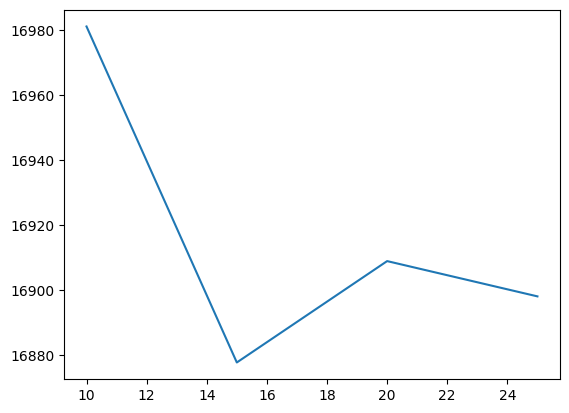

In [10]:
maximum_depth = [None, 10, 15, 20, 25]
scores = []

for val in maximum_depth:
    model = RandomForestRegressor(max_depth=val, random_state=0)
    my_pipeline = fit_model(model)
    scores.append(evaluate_model(my_pipeline))

plt.plot(maximum_depth, scores);

### 2. n_estimators
- The number of trees in the forest.
- The performance of the model sharply increases and then stagnates at a certain level.
- Choosing high number of n_estimators is not the best idea. Although it doesn't degrade the model, it increases the computational complexity.

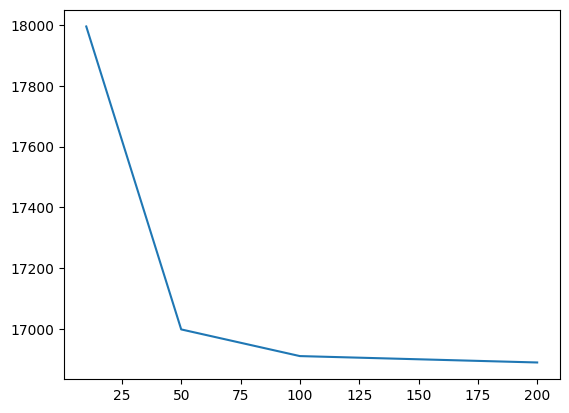

In [11]:
n_estimators = [10, 50, 100,200]
scores = []

for val in n_estimators:
    model = RandomForestRegressor(n_estimators=val, random_state=0)
    my_pipeline = fit_model(model)
    scores.append(evaluate_model(my_pipeline))

plt.plot(n_estimators, scores);

### 3. min_samples_split

- a parameter that tells the decision tree in a random forest the minimum required number of observations in any given node in order to split it.

- By increasing the number of min_samples_split, I decrease the tree height and `overfitting` as well. 

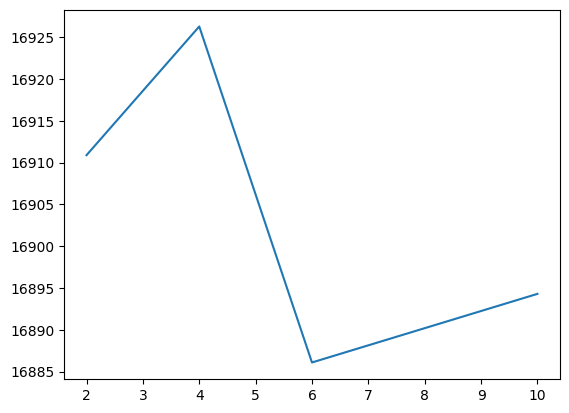

In [12]:
min_samples_split = [2,4,6,10]
scores = []

for val in min_samples_split:
    model = RandomForestRegressor(min_samples_split = val, random_state=0)
    my_pipeline = fit_model(model)
    scores.append(evaluate_model(my_pipeline))

plt.plot(min_samples_split, scores);

### 4. max_leaf_nodes

-  This hyperparameter sets a condition on the splitting of the nodes in the tree and hence restricts the growth of the tree.
- If after splitting we have more terminal nodes than the specified number of terminal nodes, it will stop the splitting and the tree will not grow further.

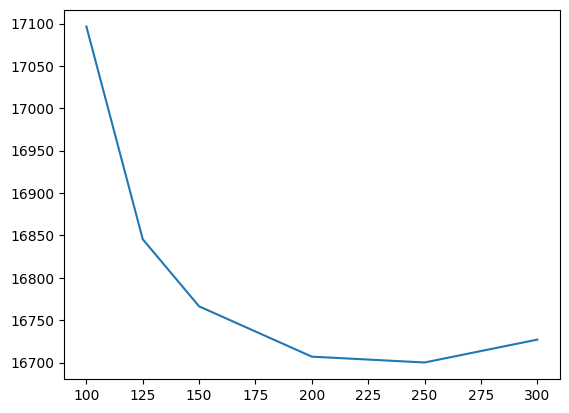

In [13]:
max_leaf_nodes = [100, 125, 150, 200, 250, 300]
scores = []

for val in max_leaf_nodes:
    model = RandomForestRegressor(max_leaf_nodes=val, random_state=0)
    my_pipeline = fit_model(model)
    scores.append(evaluate_model(my_pipeline))

plt.plot(max_leaf_nodes, scores);

### 5. min_samples_leaf
- the minimum number of samples that should be present in the leaf node after splitting a node.
- A very low value gives `overfitting`.
- A very high value gives `underfitting`.
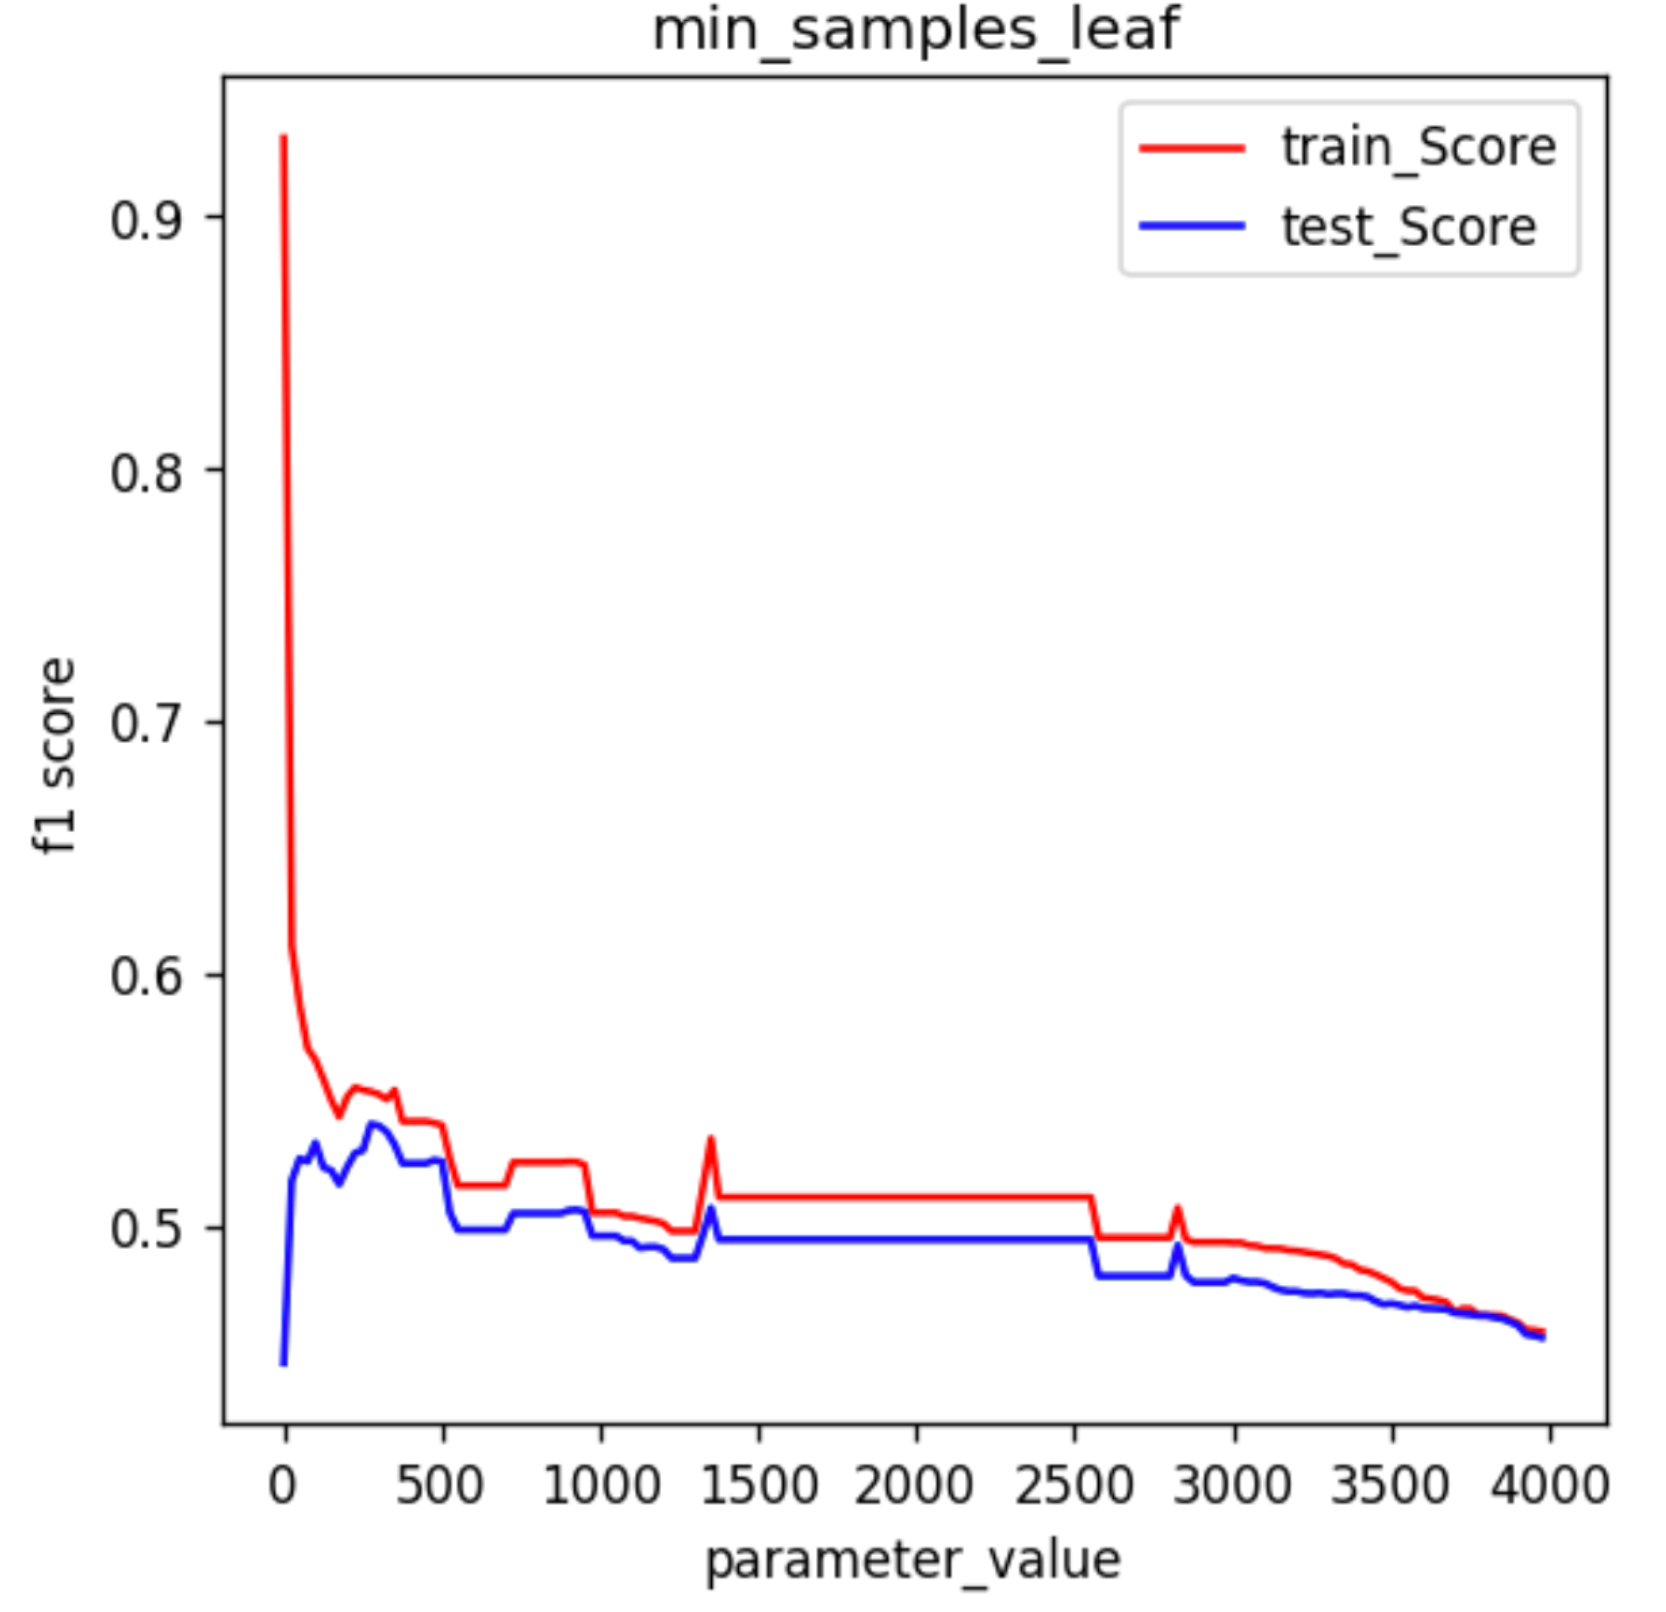

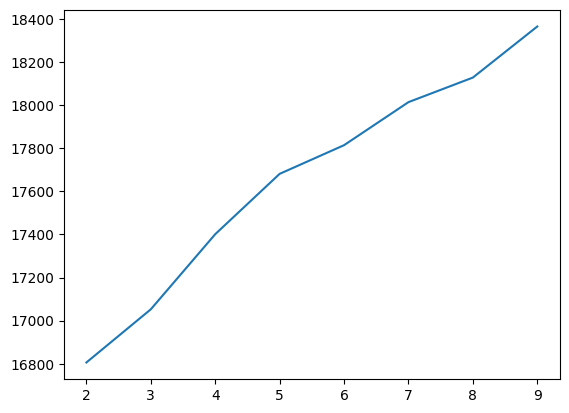

In [14]:
min_samples_leaf = [2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for val in min_samples_leaf:
    model = RandomForestRegressor(min_samples_leaf=val, random_state=0)
    my_pipeline = fit_model(model)
    scores.append(evaluate_model(my_pipeline))

plt.plot(min_samples_leaf, scores);

### 6. max_samples

- The max_samples hyperparameter determines what fraction of the original dataset is given to any individual tree. 
- We dont actually require a high fraction of data. The performance of the model rises sharply and then saturates fairly quickly.

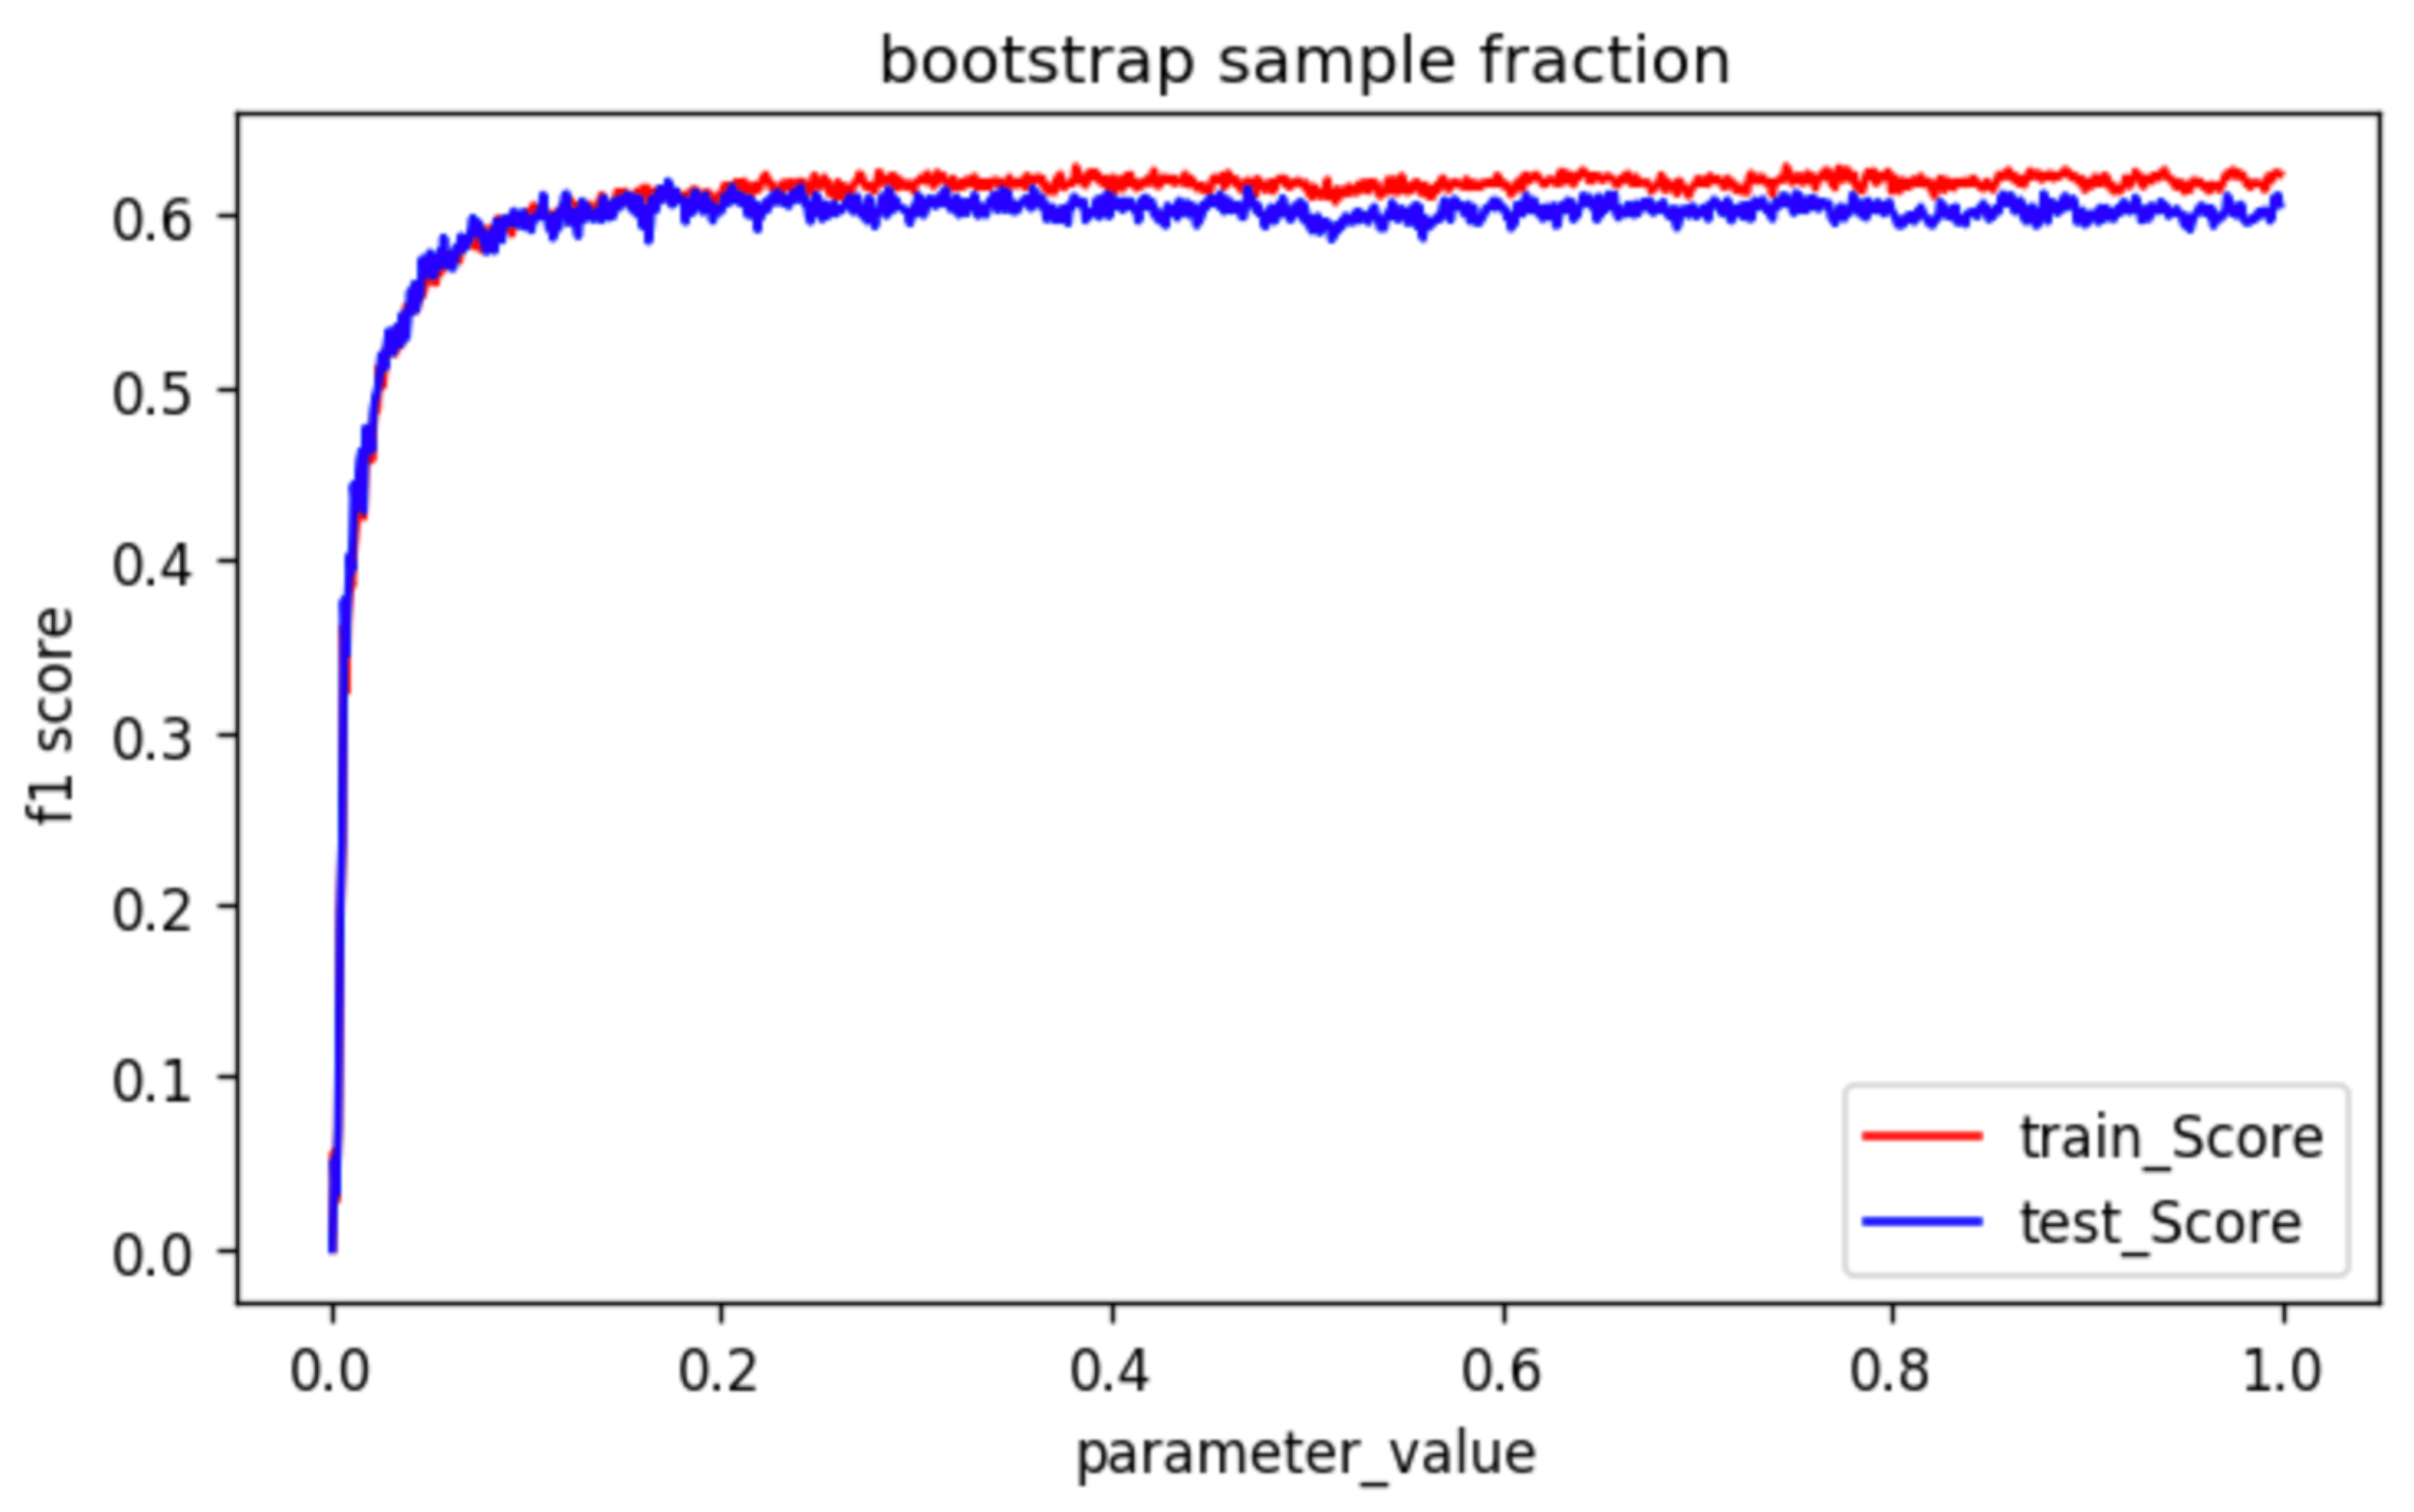

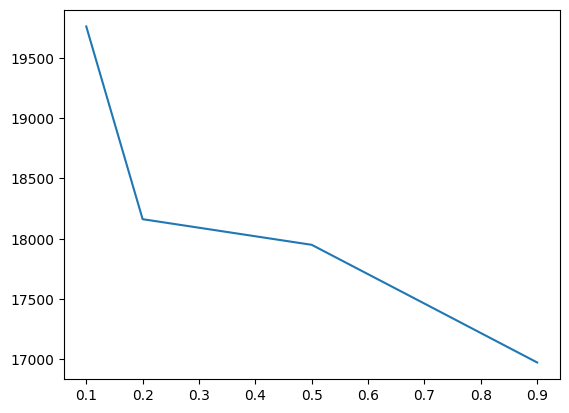

In [15]:
max_samples = [0.1, 0.2, 0.5, 0.7, 0.9]
scores = []

for val in max_samples:
    model = RandomForestRegressor(max_samples=val, random_state=0)
    my_pipeline = fit_model(model)
    scores.append(evaluate_model(my_pipeline))

plt.plot(max_samples, scores);

### 7. max_features
This resembles the number of maximum features provided to each tree in a random forest.


### RandomizedSearchCV

In [16]:
from sklearn.model_selection import RandomizedSearchCV #type:ignore

np.random.seed(0)

grid = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [10, 15, 20, 25],
    'min_samples_split' : [2, 3, 4, 5, 6],
    'max_leaf_nodes' : [150, 200, 250],
    'min_samples_leaf' : [2, 3, 4, 5],
    'max_samples' : [0.2, 0.3, 0.5, 0.7, 0.9],
    'max_features' : [None, 'sqrt']
} 

rs_model = RandomizedSearchCV(
    estimator = model,
    param_distributions = grid, 
    n_iter = 100,
    n_jobs = -1,
    verbose = 2
)

my_pipeline = fit_model(rs_model)

evaluate_model(my_pipeline)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


17621.97188343874

In [17]:
rs_model.best_params_

{'n_estimators': 200,
 'min_samples_split': 3,
 'min_samples_leaf': 4,
 'max_samples': 0.9,
 'max_leaf_nodes': 150,
 'max_features': None,
 'max_depth': 15}

In [18]:
model = RandomForestRegressor(
    max_depth=25,
    n_estimators=100,
    min_samples_split=2,
    max_leaf_nodes=200,
    min_samples_leaf=2,
    max_samples=0.9,
    random_state=0,
    max_features=None
)

my_pipeline=fit_model(model)

evaluate_model(my_pipeline)

16996.949385026506

In [19]:
save_prediction(my_pipeline)

# XGBoost

In [20]:
from xgboost import XGBRegressor #type:ignore

model = XGBRegressor(
    n_estimators = 400,
    learning_rate = 0.1,
    random_state = 0
)

my_pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

my_pipeline.fit(
    X_train,
    y_train
)

mean_absolute_error(y_val, my_pipeline.predict(X_val))

16848.195280393837

In [21]:
save_prediction(my_pipeline)